# Titanic: Machine Learning from Disaster



## column Descriptions


  * **Survival** - 생존 여부
  * **Pclass** - 티켓 등급
  * **Sex** - 성별
  * **Age** - 나이
  * **SibSp** - 동승한 형재/자매와 배우자의 총 인원 수
  * **Parch** - 동승한 부모와 자식의 총 인원 수
  * **Ticket** - 티켓 번호
  * **Fare** - 운임 요금
  * **Cabin** - 객실 번호
  * **Embarked** - 선착장

In [256]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

## Load DataSet

In [257]:
train = pd.read_csv("./train.csv", index_col="PassengerId")
print(train.shape)
train.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [258]:
test = pd.read_csv("./test.csv", index_col="PassengerId")
print(test.shape)
test.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Explore

### Sex

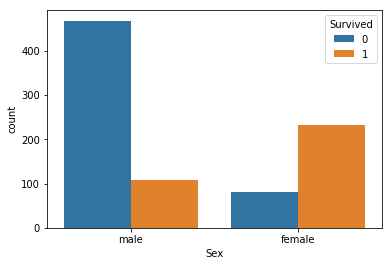

In [259]:
sns.countplot(data=train, x="Sex", hue="Survived")

In [260]:
pd.pivot_table(train, index="Sex", values="Survived")

,Survived
Sex,
female,0.742038
male,0.188908


### Pclass

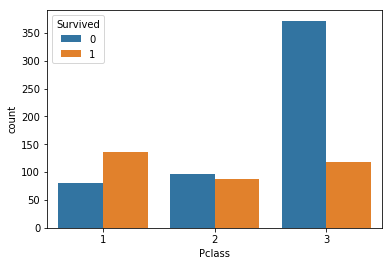

In [261]:
sns.countplot(data=train, x="Pclass", hue="Survived")

In [262]:
pd.pivot_table(train, index="Pclass", values="Survived")

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Embarked

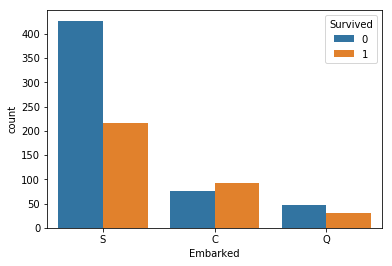

In [263]:
sns.countplot(data=train, x="Embarked", hue="Survived")

In [264]:
pd.pivot_table(train, index="Embarked", values="Survived")

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


### Age & Fare

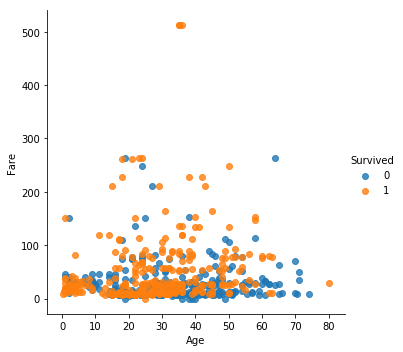

In [265]:
sns.lmplot(data=train, x="Age", y="Fare", hue="Survived", fit_reg=False)

In [266]:
low_fare = train[train["Fare"] < 100]
train.shape, low_fare.shape

((891, 11), (838, 11))

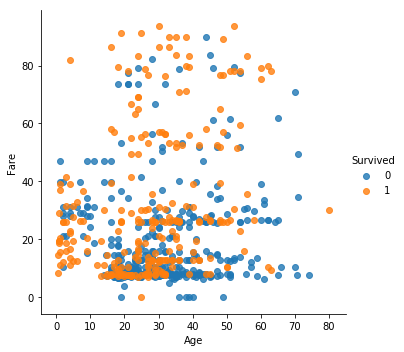

In [267]:
sns.lmplot(data=low_fare, x="Age", y="Fare", hue="Survived", fit_reg=False)

### SibSp, Parch

In [268]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
print(train.shape)
train[["SibSp", "Parch", "FamilySize"]].head()

(891, 12)


,SibSp,Parch,FamilySize
PassengerId,,,
1,1,0,2
2,1,0,2
3,0,0,1
4,1,0,2
5,0,0,1


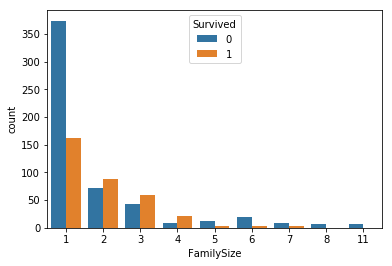

In [269]:
sns.countplot(data=train, x="FamilySize", hue="Survived")

In [270]:
train.loc[train["FamilySize"] == 1, "FamilyType"] = "Single"
train.loc[(train["FamilySize"] > 1) & (train["FamilySize"] < 5), "FamilyType"] = "Nuclear"
train.loc[train["FamilySize"] >= 5, "FamilyType"] = "Big"
print(train.shape)
train[["FamilySize", "FamilyType"]].head(10)

(891, 13)


,FamilySize,FamilyType
PassengerId,,
1,2,Nuclear
2,2,Nuclear
3,1,Single
4,2,Nuclear
5,1,Single
6,1,Single
7,1,Single
8,5,Big
9,3,Nuclear


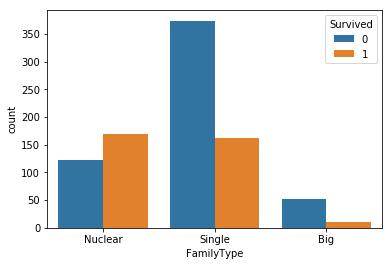

In [271]:
sns.countplot(data=train, x="FamilyType", hue="Survived")

In [272]:
pd.pivot_table(data=train, index="FamilyType", values="Survived")

,Survived
FamilyType,
Big,0.161290
Nuclear,0.578767
Single,0.303538


### Name

In [273]:
train["Name"].head()

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: object

In [274]:
def get_title(name):
    return name.split(", ")[1].split('. ')[0]

train["Name"].apply(get_title).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [275]:
train.loc[train["Name"].str.contains("Mr"), "Title"] = "Mr"
train.loc[train["Name"].str.contains("Miss"), "Title"] = "Miss"
train.loc[train["Name"].str.contains("Mrs"), "Title"] = "Mrs"
train.loc[train["Name"].str.contains("Master"), "Title"] = "Master"
print(train.shape)
train[["Name", "Title"]].head(10)

(891, 14)


,Name,Title
PassengerId,,
1,"Braund, Mr. Owen Harris",Mr
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
3,"Heikkinen, Miss. Laina",Miss
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
5,"Allen, Mr. William Henry",Mr
6,"Moran, Mr. James",Mr
7,"McCarthy, Mr. Timothy J",Mr
8,"Palsson, Master. Gosta Leonard",Master
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs


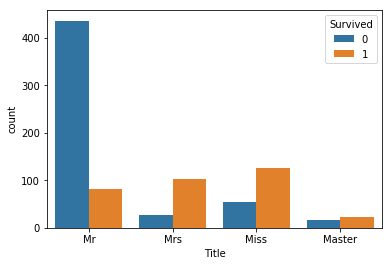

In [276]:
sns.countplot(data=train, x="Title", hue="Survived")

In [277]:
pd.pivot_table(train, index="Title", values="Survived")

,Survived
Title,
Master,0.575000
Miss,0.700000
Mr,0.158301
Mrs,0.790698


## Preprocess

### Sex

In [278]:
train.loc[train["Sex"] == "male", "Sex_encode"] = 0
train.loc[train["Sex"] == "female", "Sex_encode"] = 1
print(train.shape)
train.head()

(891, 15)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyType,Title,Sex_encode
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Nuclear,Mr,0.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Nuclear,Mrs,1.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Single,Miss,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Nuclear,Mrs,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Single,Mr,0.0


In [279]:
test.loc[test["Sex"] == "male", "Sex_encode"] = 0
test.loc[test["Sex"] == "female", "Sex_encode"] = 1
print(test.shape)
test[["Sex", "Sex_encode"]].head()

(418, 11)


,Sex,Sex_encode
PassengerId,,
892,male,0.0
893,female,1.0
894,male,0.0
895,male,0.0
896,female,1.0


### Fare, filling in missing data

In [280]:
train[train["Fare"].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyType,Title,Sex_encode
PassengerId,,,,,,,,,,,,,,,


In [281]:
test[test["Fare"].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encode
PassengerId,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0.0


In [282]:
train["Fare_fillin"] = train["Fare"]
print(train.shape)
train[["Fare", "Fare_fillin"]].head()

(891, 16)


,Fare,Fare_fillin
PassengerId,,
1,7.2500,7.2500
2,71.2833,71.2833
3,7.9250,7.9250
4,53.1000,53.1000
5,8.0500,8.0500


In [283]:
test["Fare_fillin"] = test["Fare"]
print(test.shape)
test[["Fare", "Fare_fillin"]].head()

(418, 12)


,Fare,Fare_fillin
PassengerId,,
892,7.8292,7.8292
893,7.0000,7.0000
894,9.6875,9.6875
895,8.6625,8.6625
896,12.2875,12.2875


In [284]:
test.loc[test["Fare"].isnull(), "Fare_fillin"] = 0
test.loc[test["Fare"].isnull(), ["Fare", "Fare_fillin"]]

,Fare,Fare_fillin
PassengerId,,
1044,NaN,0.0


### Embarked

In [285]:
train["Embarked_C"] = train["Embarked"] == "C"
train["Embarked_S"] = train["Embarked"] == "S"
train["Embarked_Q"] = train["Embarked"] == "Q"
print(train.shape)
train[["Embarked", "Embarked_C", "Embarked_S", "Embarked_Q"]].head()

(891, 19)


,Embarked,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,
1,S,False,True,False
2,C,True,False,False
3,S,False,True,False
4,S,False,True,False
5,S,False,True,False


In [286]:
test["Embarked_C"] = test["Embarked"] == "C"
test["Embarked_S"] = test["Embarked"] == "S"
test["Embarked_Q"] = test["Embarked"] == "Q"
print(test.shape)
test[["Embarked", "Embarked_C", "Embarked_S", "Embarked_Q"]].head()

(418, 15)


,Embarked,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,
892,Q,False,False,True
893,S,False,True,False
894,Q,False,False,True
895,S,False,True,False
896,S,False,True,False


### Age - under 15 -> child

In [287]:
train["Child"] = train["Age"] < 15
print(train.shape)
train[["Age", "Child"]].head(10)

(891, 20)


,Age,Child
PassengerId,,
1,22.0,False
2,38.0,False
3,26.0,False
4,35.0,False
5,35.0,False
6,NaN,False
7,54.0,False
8,2.0,True
9,27.0,False


In [288]:
test["Child"] = test["Age"] < 15
print(test.shape)
test[["Age", "Child"]].head(10)

(418, 16)


,Age,Child
PassengerId,,
892,34.5,False
893,47.0,False
894,62.0,False
895,27.0,False
896,22.0,False
897,14.0,True
898,30.0,False
899,26.0,False
900,18.0,False


### SibSp, Parch -> FamilySize

In [289]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
print(train.shape)
train[["SibSp", "Parch", "FamilySize"]].head()

(891, 20)


,SibSp,Parch,FamilySize
PassengerId,,,
1,1,0,2
2,1,0,2
3,0,0,1
4,1,0,2
5,0,0,1


In [290]:
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
print(test.shape)
test[["SibSp", "Parch", "FamilySize"]].head()

(418, 17)


,SibSp,Parch,FamilySize
PassengerId,,,
892,0,0,1
893,1,0,2
894,0,0,1
895,0,0,1
896,1,1,3


In [291]:
train["Single"] = train["FamilySize"] == 1
train["Nuclear"] = (train["FamilySize"] > 1) & (train["FamilySize"] < 5)
train["Big"] = train["FamilySize"] >= 5
print(train.shape)
train[["FamilySize", "Single", "Nuclear", "Big"]].head(10)

(891, 23)


,FamilySize,Single,Nuclear,Big
PassengerId,,,,
1,2,False,True,False
2,2,False,True,False
3,1,True,False,False
4,2,False,True,False
5,1,True,False,False
6,1,True,False,False
7,1,True,False,False
8,5,False,False,True
9,3,False,True,False


In [292]:
test["Single"] = test["FamilySize"] == 1
test["Nuclear"] = (test["FamilySize"] > 1) & (test["FamilySize"] < 5)
test["Big"] = test["FamilySize"] >= 5
print(test.shape)
test[["FamilySize", "Single", "Nuclear", "Big"]].head(10)

(418, 20)


,FamilySize,Single,Nuclear,Big
PassengerId,,,,
892,1,True,False,False
893,2,False,True,False
894,1,True,False,False
895,1,True,False,False
896,3,False,True,False
897,1,True,False,False
898,1,True,False,False
899,3,False,True,False
900,1,True,False,False


### Name

In [293]:
train["Master"] = train["Name"].str.contains("Master")
print(train.shape)
train[["Name", "Master"]].head(10)

(891, 24)


,Name,Master
PassengerId,,
1,"Braund, Mr. Owen Harris",False
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False
3,"Heikkinen, Miss. Laina",False
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False
5,"Allen, Mr. William Henry",False
6,"Moran, Mr. James",False
7,"McCarthy, Mr. Timothy J",False
8,"Palsson, Master. Gosta Leonard",True
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",False


In [294]:
test["Master"] = test["Name"].str.contains("Master")
print(test.shape)
test[["Name", "Master"]].head(10)

(418, 21)


,Name,Master
PassengerId,,
892,"Kelly, Mr. James",False
893,"Wilkes, Mrs. James (Ellen Needs)",False
894,"Myles, Mr. Thomas Francis",False
895,"Wirz, Mr. Albert",False
896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",False
897,"Svensson, Mr. Johan Cervin",False
898,"Connolly, Miss. Kate",False
899,"Caldwell, Mr. Albert Francis",False
900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",False


## Train

In [295]:
feature_names = ["Pclass", "Sex_encode", "Fare_fillin", "Embarked_C", "Embarked_S", "Embarked_Q", "Child", "Single", "Nuclear", "Big", "Master"]
feature_names

['Pclass',
 'Sex_encode',
 'Fare_fillin',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q',
 'Child',
 'Single',
 'Nuclear',
 'Big',
 'Master']

In [296]:
label_name = "Survived"
label_name

'Survived'

In [297]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(891, 11)


,Pclass,Sex_encode,Fare_fillin,Embarked_C,Embarked_S,Embarked_Q,Child,Single,Nuclear,Big,Master
PassengerId,,,,,,,,,,,
1,3,0.0,7.2500,False,True,False,False,False,True,False,False
2,1,1.0,71.2833,True,False,False,False,False,True,False,False
3,3,1.0,7.9250,False,True,False,False,True,False,False,False
4,1,1.0,53.1000,False,True,False,False,False,True,False,False
5,3,0.0,8.0500,False,True,False,False,True,False,False,False


In [298]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(418, 11)


,Pclass,Sex_encode,Fare_fillin,Embarked_C,Embarked_S,Embarked_Q,Child,Single,Nuclear,Big,Master
PassengerId,,,,,,,,,,,
892,3,0.0,7.8292,False,False,True,False,True,False,False,False
893,3,1.0,7.0000,False,True,False,False,False,True,False,False
894,2,0.0,9.6875,False,False,True,False,True,False,False,False
895,3,0.0,8.6625,False,True,False,False,True,False,False,False
896,3,1.0,12.2875,False,True,False,False,False,True,False,False


In [299]:
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(891,)


PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

### Stacking

In [300]:
models = []
random_state=11
models.append(SVC(random_state=random_state))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(XGBClassifier(random_state=random_state))
models.append(KNeighborsClassifier())
models.append(MLPClassifier(random_state=random_state))

In [301]:
kf = KFold(n_splits=3)
i = 0
for model in models:
    i += 1
    feature_names.append(("model" + str(i)))
    for train_index, test_index in kf.split(X_train):
        train_index += 1
        test_index += 1
        X_train_index, X_test_index = X_train.loc[train_index], X_train.loc[test_index]
        y_train_index, y_test_index = y_train.loc[train_index], y_train.loc[test_index]        
        model.fit(X_train_index, y_train_index)
        prediction_train = model.predict(X_test_index)
        train.loc[test_index, ("model" + str(i))] = prediction_train
    
    prediction_test = model.predict(X_test)
    test[("model") + str(i)] = prediction_test

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

#### "----------------"

In [302]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [303]:
model = CatBoostClassifier(random_state=random_state)

In [304]:
model.fit(X_train, y_train)

Learning rate set to 0.016216
0:	learn: 0.6817867	total: 102ms	remaining: 1m 41s
1:	learn: 0.6711029	total: 148ms	remaining: 1m 13s
2:	learn: 0.6619681	total: 161ms	remaining: 53.4s
3:	learn: 0.6528059	total: 175ms	remaining: 43.7s
4:	learn: 0.6431854	total: 195ms	remaining: 38.8s
5:	learn: 0.6346299	total: 238ms	remaining: 39.5s
6:	learn: 0.6245776	total: 257ms	remaining: 36.5s
7:	learn: 0.6152682	total: 274ms	remaining: 34s
8:	learn: 0.6067561	total: 291ms	remaining: 32.1s
9:	learn: 0.5998162	total: 313ms	remaining: 30.9s
10:	learn: 0.5921707	total: 332ms	remaining: 29.9s
11:	learn: 0.5864209	total: 346ms	remaining: 28.5s
12:	learn: 0.5781207	total: 362ms	remaining: 27.5s
13:	learn: 0.5722499	total: 375ms	remaining: 26.4s
14:	learn: 0.5671063	total: 401ms	remaining: 26.3s
15:	learn: 0.5603409	total: 450ms	remaining: 27.7s
16:	learn: 0.5540160	total: 470ms	remaining: 27.2s
17:	learn: 0.5498625	total: 485ms	remaining: 26.5s
18:	learn: 0.5445603	total: 504ms	remaining: 26s
19:	learn: 0.

163:	learn: 0.3572839	total: 4.44s	remaining: 22.7s
164:	learn: 0.3568289	total: 4.47s	remaining: 22.6s
165:	learn: 0.3564628	total: 4.51s	remaining: 22.6s
166:	learn: 0.3562428	total: 4.53s	remaining: 22.6s
167:	learn: 0.3561033	total: 4.54s	remaining: 22.5s
168:	learn: 0.3558533	total: 4.56s	remaining: 22.4s
169:	learn: 0.3557656	total: 4.58s	remaining: 22.4s
170:	learn: 0.3554985	total: 4.6s	remaining: 22.3s
171:	learn: 0.3553326	total: 4.61s	remaining: 22.2s
172:	learn: 0.3549215	total: 4.63s	remaining: 22.1s
173:	learn: 0.3546538	total: 4.65s	remaining: 22.1s
174:	learn: 0.3540755	total: 4.69s	remaining: 22.1s
175:	learn: 0.3535952	total: 4.71s	remaining: 22.1s
176:	learn: 0.3531795	total: 4.73s	remaining: 22s
177:	learn: 0.3530549	total: 4.75s	remaining: 21.9s
178:	learn: 0.3529749	total: 4.76s	remaining: 21.8s
179:	learn: 0.3528844	total: 4.78s	remaining: 21.8s
180:	learn: 0.3528483	total: 4.79s	remaining: 21.7s
181:	learn: 0.3527059	total: 4.81s	remaining: 21.6s
182:	learn: 0.3

323:	learn: 0.3317231	total: 8.13s	remaining: 17s
324:	learn: 0.3316423	total: 8.17s	remaining: 17s
325:	learn: 0.3314990	total: 8.23s	remaining: 17s
326:	learn: 0.3314262	total: 8.27s	remaining: 17s
327:	learn: 0.3314229	total: 8.32s	remaining: 17s
328:	learn: 0.3313408	total: 8.37s	remaining: 17.1s
329:	learn: 0.3313299	total: 8.39s	remaining: 17s
330:	learn: 0.3313251	total: 8.41s	remaining: 17s
331:	learn: 0.3313203	total: 8.45s	remaining: 17s
332:	learn: 0.3313123	total: 8.5s	remaining: 17s
333:	learn: 0.3312992	total: 8.52s	remaining: 17s
334:	learn: 0.3312813	total: 8.56s	remaining: 17s
335:	learn: 0.3312384	total: 8.61s	remaining: 17s
336:	learn: 0.3312029	total: 8.64s	remaining: 17s
337:	learn: 0.3312029	total: 8.68s	remaining: 17s
338:	learn: 0.3311476	total: 8.73s	remaining: 17s
339:	learn: 0.3311457	total: 8.77s	remaining: 17s
340:	learn: 0.3311428	total: 8.78s	remaining: 17s
341:	learn: 0.3310760	total: 8.84s	remaining: 17s
342:	learn: 0.3310008	total: 8.88s	remaining: 17s

487:	learn: 0.3195624	total: 13.5s	remaining: 14.1s
488:	learn: 0.3195496	total: 13.5s	remaining: 14.1s
489:	learn: 0.3193953	total: 13.5s	remaining: 14.1s
490:	learn: 0.3193787	total: 13.6s	remaining: 14.1s
491:	learn: 0.3193650	total: 13.6s	remaining: 14s
492:	learn: 0.3192551	total: 13.6s	remaining: 14s
493:	learn: 0.3191912	total: 13.7s	remaining: 14s
494:	learn: 0.3190494	total: 13.7s	remaining: 14s
495:	learn: 0.3189111	total: 13.7s	remaining: 14s
496:	learn: 0.3188940	total: 13.8s	remaining: 14s
497:	learn: 0.3188429	total: 13.8s	remaining: 13.9s
498:	learn: 0.3187544	total: 13.8s	remaining: 13.9s
499:	learn: 0.3185482	total: 13.8s	remaining: 13.8s
500:	learn: 0.3184035	total: 13.9s	remaining: 13.8s
501:	learn: 0.3183870	total: 13.9s	remaining: 13.8s
502:	learn: 0.3182151	total: 13.9s	remaining: 13.7s
503:	learn: 0.3181463	total: 13.9s	remaining: 13.7s
504:	learn: 0.3181238	total: 14s	remaining: 13.7s
505:	learn: 0.3180471	total: 14s	remaining: 13.7s
506:	learn: 0.3178847	total:

650:	learn: 0.3063786	total: 18.3s	remaining: 9.81s
651:	learn: 0.3063327	total: 18.4s	remaining: 9.8s
652:	learn: 0.3062287	total: 18.4s	remaining: 9.77s
653:	learn: 0.3061438	total: 18.4s	remaining: 9.73s
654:	learn: 0.3060898	total: 18.4s	remaining: 9.7s
655:	learn: 0.3060273	total: 18.4s	remaining: 9.66s
656:	learn: 0.3060034	total: 18.4s	remaining: 9.63s
657:	learn: 0.3060018	total: 18.5s	remaining: 9.6s
658:	learn: 0.3058435	total: 18.5s	remaining: 9.56s
659:	learn: 0.3057857	total: 18.5s	remaining: 9.53s
660:	learn: 0.3057729	total: 18.5s	remaining: 9.49s
661:	learn: 0.3057238	total: 18.6s	remaining: 9.47s
662:	learn: 0.3056738	total: 18.6s	remaining: 9.44s
663:	learn: 0.3056035	total: 18.6s	remaining: 9.41s
664:	learn: 0.3053354	total: 18.6s	remaining: 9.37s
665:	learn: 0.3051429	total: 18.6s	remaining: 9.34s
666:	learn: 0.3051249	total: 18.6s	remaining: 9.31s
667:	learn: 0.3050750	total: 18.7s	remaining: 9.27s
668:	learn: 0.3049991	total: 18.7s	remaining: 9.24s
669:	learn: 0.3

814:	learn: 0.2969841	total: 22.4s	remaining: 5.08s
815:	learn: 0.2969829	total: 22.4s	remaining: 5.06s
816:	learn: 0.2969679	total: 22.4s	remaining: 5.03s
817:	learn: 0.2969535	total: 22.5s	remaining: 5s
818:	learn: 0.2968659	total: 22.5s	remaining: 4.97s
819:	learn: 0.2967680	total: 22.5s	remaining: 4.94s
820:	learn: 0.2967679	total: 22.5s	remaining: 4.91s
821:	learn: 0.2967304	total: 22.5s	remaining: 4.88s
822:	learn: 0.2966356	total: 22.6s	remaining: 4.85s
823:	learn: 0.2965487	total: 22.6s	remaining: 4.82s
824:	learn: 0.2965008	total: 22.6s	remaining: 4.79s
825:	learn: 0.2965007	total: 22.6s	remaining: 4.77s
826:	learn: 0.2964679	total: 22.7s	remaining: 4.74s
827:	learn: 0.2963550	total: 22.7s	remaining: 4.71s
828:	learn: 0.2963201	total: 22.7s	remaining: 4.68s
829:	learn: 0.2962407	total: 22.7s	remaining: 4.65s
830:	learn: 0.2962166	total: 22.7s	remaining: 4.62s
831:	learn: 0.2962019	total: 22.8s	remaining: 4.59s
832:	learn: 0.2962006	total: 22.8s	remaining: 4.56s
833:	learn: 0.2

974:	learn: 0.2890773	total: 27.1s	remaining: 695ms
975:	learn: 0.2890493	total: 27.1s	remaining: 667ms
976:	learn: 0.2889905	total: 27.2s	remaining: 640ms
977:	learn: 0.2889372	total: 27.2s	remaining: 612ms
978:	learn: 0.2889247	total: 27.2s	remaining: 584ms
979:	learn: 0.2889033	total: 27.2s	remaining: 556ms
980:	learn: 0.2888355	total: 27.3s	remaining: 528ms
981:	learn: 0.2887659	total: 27.3s	remaining: 500ms
982:	learn: 0.2887386	total: 27.3s	remaining: 472ms
983:	learn: 0.2886908	total: 27.3s	remaining: 445ms
984:	learn: 0.2886907	total: 27.4s	remaining: 417ms
985:	learn: 0.2886903	total: 27.5s	remaining: 390ms
986:	learn: 0.2886616	total: 27.5s	remaining: 362ms
987:	learn: 0.2885327	total: 27.6s	remaining: 335ms
988:	learn: 0.2885326	total: 27.6s	remaining: 307ms
989:	learn: 0.2884907	total: 27.6s	remaining: 279ms
990:	learn: 0.2884645	total: 27.6s	remaining: 251ms
991:	learn: 0.2884352	total: 27.6s	remaining: 223ms
992:	learn: 0.2884005	total: 27.7s	remaining: 195ms
993:	learn: 

In [305]:
prediction = model.predict(X_test)

In [317]:
feature_names

['Pclass',
 'Sex_encode',
 'Fare_fillin',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q',
 'Child',
 'Single',
 'Nuclear',
 'Big',
 'Master',
 'model1',
 'model2',
 'model3',
 'model4',
 'model5',
 'model6']

In [306]:
submission = pd.read_csv("./submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [311]:
submission["Survived"] = prediction.astype(int)

In [312]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [313]:
submission.to_csv("./stack.csv", index=False)